### Name Classification 
Based on https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In this notebook we will classify names with the help of pytorch. The names that we look at will be from 18 different languages.

We will show the following

1) The dataset class and dataloader from pytorch

2) A basic neural network

3) Rnn, lstm and Gru.


### The dataset

Our dataset consists of names from different languages, e.g. Hanz is a german name, Antonowitsch is a Czech name etc...

We must think of a way of repressenting these names, such that a neural network can work with it.
First of all, we need to make sure that the letters can be interpreted by a neural network, we do this by mapping each letter to a one-hot encoding. Secondly, we need to make sure that the input lenghts of every name is the same. We can solve this by using by padding each name with padding characters.

We will start by some handy funcionts that will help us with this task.


In [1]:
# First load all the relavent packages
# Creating a custom dataset
from io import open
import glob
import os

import unicodedata
import string
import numpy as np

In [5]:

all_letters = string.ascii_letters + " .,;'"  "0" #We add 0 to pad the sequences 
n_letters = len(all_letters)


# Because some names have weird characters such as "é" we map them to standard Ascii caracters.
# Basically maps weird characters to the standard 26 letter alphabet e.g. é -> e
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


# Read the lines of a file
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]
def find_files(path): return glob.glob(path)

# Find the index of a letter in our alphabet
def letter_to_index(letter):
    return all_letters.find(letter)


# Creates a tensor containing one-hot vectors for the name. 
def name_to_tensor(name):
    tensor = torch.zeros(len(name), n_letters)
    count = 0
    for li, letter in enumerate(name):
        tensor[li][letterToIndex(letter)] = 1
    return tensor

# Each categorie is also mapped to a tensor.
def categorie_to_tensor(index, num_categories):
    t = torch.zeros(num_categories, dtype=torch.long)
    t[index] = 1.0
    return t

In [8]:
# We will now create dataset object that handles loading the data.
from torch.utils.data import Dataset
import torch

# A dataset class needs to have 3 functions: __init__, __get_item__ and __len__
class NameDataset(Dataset):
    
    def __init__(self, data_root):
        self.samples = [] # Will contain the samples in the form (name, language)
        self.all_categories = [] # list of all the different languages
        
        # We read each file in the folder and parses it to get the samples.
        for filename in findFiles( data_root + '*.txt'):
            category = os.path.splitext(os.path.basename(filename))[0]
            self.all_categories.append(category)
            lines = readLines(filename)
            for line in lines:
                self.samples.append((line, category))
        
        # Keeps track of the number of categories
        self.num_categories = len(self.all_categories)
        
    
        #pad the sequences to the appropiate length
        self.pad_sequences()

        #Lastly make sure that each name and categorie is a tensor
        self.convert_samples_to_tensors()


    def pad_sequences(self):
        
        #We want to pad the sequence to the length of the longest name.
        self.max_len = np.max([len(name) for name, categorie in self.samples])
        self.samples = [(name + "0" * (self.max_len - len(name)), categorie) for name, categorie in self.samples]
        
    def convert_samples_to_tensors(self):
         self.samples = [(nameToTensor(name), self.all_categories.index(language) ) for name, language in self.samples]
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    


In [9]:
### Next we initialize the dataset and put it into a dataloader, we also make a test set and a train set.


dataset = NameDataset('names/')
test_num = int(0.2 * len(dataset))
train_num = len(dataset) - test_num
train_dataset, test_dataset = random_split(dataset, [train_num, test_num])
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False) # No need to shuffle

In [14]:
# We look at the dataset
for i, batch in enumerate(train_dataloader):
    print(batch)
    print(batch[0].shape)
    break

[tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,

### The neural network

We will create a simple 3 layer feed forward neural network to start with. 
We do this by creating a class that extends nn.Module. For this we need to define two things:

1) The '__init__'

2) The 'forward' function with gets as input a name and produces a vector containing the probabilities of that name belonging to each language

In [65]:
import torch.nn as nn 
from torch.nn import functional as F # F contains functions that are not trainable, e.g. softmax, sigmoid, relu etc..

class SmallNetwork(nn.Module):
    
    def __init__(self, input_len, n_letters):
        super(SmallNetwork, self).__init__()
        self.input_len = input_len
        self.first_layer = nn.Linear(input_len * n_letters, 128)
        self.second_layer = nn.Linear(128, 64)
        self.output = nn.Linear(64, n_letters)
        
    def forward(self, name):
        x =  name.view(-1, self.first_layer.in_features)
        x = self.first_layer(x)
        x = F.relu(x)
        x = self.second_layer(x)
        x = F.relu(x)
        x = self.output(x)
        return F.log_softmax(x, dim=-1)


### Training

Next up we define the train and test functions, and a way of plotting the results. 



In [91]:
import matplotlib.pyplot as plt
def train(model,criterion, optimizer, n_epochs, dataloader, test_callback=None):
    '''
        Model: the model to train.
        criterion: the loss function.
        optimizer: the function that is used to update the weights.
        n_epochs: number of epochs.
        dataloader: the dataloader that is used to get samples.
        test_callback: a callback that is used to test the model.
    '''
    loss_history = []
    test_history = []
    for epoch in range(1, n_epochs + 1):
        epoch_total_loss = 0
        for i, (names, cat) in enumerate(dataloader):
            optimizer.zero_grad() # Clears existing gradients from previous epoch
            
            
            output = model(names)

            loss = criterion(output, cat)
            loss.backward() # Does backpropagation and calculates gradients
            optimizer.step() # Updates the weights accordingly
            
            epoch_total_loss += loss.item() # Keep track of the total loss
        loss_history.append(epoch_total_loss/len(dataloader))
        
        if test_callback != None:
            test_history.append(test_callback(model, criterion))

        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(epoch_total_loss/ len(dataloader)))
    return loss_history, test_history
        
        
def test(model, criterion, dataloader):
    with torch.no_grad():
        total_loss = 0
        for i, (names, cat) in enumerate(dataloader):
            output = model(names)
            loss = criterion(output, cat)
            total_loss += loss.item()
        print("Test loss: {:.4f}".format(total_loss/len(dataloader)))
    return total_loss/len(dataloader)
            


def plot_train_test_history(train_history, test_history):
    x = [x for x in range(1, len(train_history)+ 1)]
    plt.plot(x, train_history)
    plt.plot(x, test_history)
    plt.show()

In [79]:
### Now we initialize the bunch
small_net = SmallNetwork(dataset.max_len, n_letters)

lr=0.01

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(small_net.parameters(), lr=lr)
n_epochs = 50


test_callback = lambda model, criterion: test(model, criterion, test_dataloader) # Creates a callback that can be used to test the network on the given dataloader


In [83]:
# Lastly the actual training
train_history, test_history = train(small_net, criterion, optimizer, n_epochs, train_dataloader, test_callback=test_callback)

Test loss: 2.2269
Epoch: 1/50............. Loss: 0.1687
Test loss: 2.1765
Epoch: 2/50............. Loss: 0.1604
Test loss: 2.2795
Epoch: 3/50............. Loss: 0.1646
Test loss: 2.2185
Epoch: 4/50............. Loss: 0.1648
Test loss: 2.2950
Epoch: 5/50............. Loss: 0.1853
Test loss: 2.3660
Epoch: 6/50............. Loss: 0.1549
Test loss: 2.4572
Epoch: 7/50............. Loss: 0.1568
Test loss: 2.3862
Epoch: 8/50............. Loss: 0.1481
Test loss: 2.3398
Epoch: 9/50............. Loss: 0.1559
Test loss: 2.4228
Epoch: 10/50............. Loss: 0.1445
Test loss: 2.4873
Epoch: 11/50............. Loss: 0.1509
Test loss: 2.4400
Epoch: 12/50............. Loss: 0.1656
Test loss: 2.4585
Epoch: 13/50............. Loss: 0.1602
Test loss: 2.4947
Epoch: 14/50............. Loss: 0.1503
Test loss: 2.4064
Epoch: 15/50............. Loss: 0.1544
Test loss: 2.4662
Epoch: 16/50............. Loss: 0.1553
Test loss: 2.5662
Epoch: 17/50............. Loss: 0.1552
Test loss: 2.5108
Epoch: 18/50..........

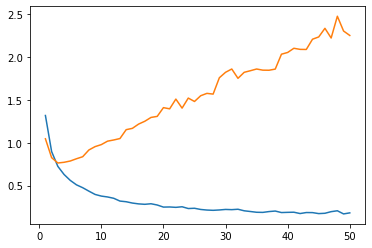

In [69]:
plot_train_test_history(train_history, test_history)

In [70]:
# As you can see there is a lot of overfitting, one easy way to counteract this is with early stopping


In [78]:
small_net = SmallNetwork(dataset.max_len, n_letters)

lr=0.01

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(small_net.parameters(), lr=lr)
n_epochs = 4


test_callback = lambda model, criterion: test(model, criterion, test_dataloader) # Creates a callback that can be used to test the network on the given dataloader


In [72]:
train_history, test_history = train(small_net, criterion, optimizer, n_epochs, train_dataloader, test_callback=test_callback)

Test loss: 1.0250
Epoch: 1/4............. Loss: 1.3244
Test loss: 0.8323
Epoch: 2/4............. Loss: 0.9035
Test loss: 0.8096
Epoch: 3/4............. Loss: 0.7476
Test loss: 0.7564
Epoch: 4/4............. Loss: 0.6419


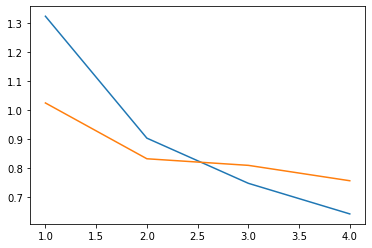

In [73]:
plot_train_test_history(train_history, test_history)

In [84]:
#Lastly we will look at some sample names

def predict(name, model):
    
    # First we pad the name
    padded_name = name + "0" * (model.input_len - len(name))
    name_tensor = name_to_tensor(padded_name)
    prediction = model(name_tensor.view(1, -1, n_letters))
    detached_prediction = prediction.detach()
    return dataset.all_categories[np.argmax(detached_prediction[0])]

In [85]:
names = ["Hanz", 'Hans', 'Tsi', 'Roberto', 'Roberta', 'Antonowitsch']
for name in names:
    print(name, predict(name, small_net))

Hanz German
Hans German
Tsi Chinese
Roberto French
Roberta Italian
Antonowitsch Czech


### Better models. 

There are two issues with this model:

1) It is not the best model, makes weird mistakes even on small dataset. 

2) it can only take names of length 19. What if we added some crazy other language which has names of length greater then 19? Or what if we have language with only very small names. Then we give the neural network a lot of info it is not using. For this we can use RNNs.

Exercise:

Create 3 different rnn models (vanilla, gru, lstm) and compare their performance

In [104]:
import torch.nn as nn 
from torch.nn import functional as F
n_hidden = 128


class RNNModel(nn.Module):

    def __init__(self, n_letters, n_hidden, num_categories):
        super(RNNModel, self).__init__()
        self.name = "rnn"
        self.rnn = nn.RNN(n_letters, n_hidden, batch_first=True,)
        self.fc = nn.Linear(n_hidden, num_categories)

    def forward(self, name):
        rnn_out, _ = self.rnn(name)
        fc_out = self.fc(rnn_out[:, -1 ]) # Only need the last output of the rnn
        return F.log_softmax(fc_out, dim=1)
        

class LSTMModel(nn.Module):

    def __init__(self, n_letters, n_hidden, num_categories):
        super(LSTMModel, self).__init__()
        self.name = "lstm"
        self.rnn = nn.LSTM(n_letters, n_hidden, batch_first=True,)
        self.fc = nn.Linear(n_hidden, num_categories)

    def forward(self, name):
        rnn_out, _ = self.rnn(name)
        fc_out = self.fc(rnn_out[:, -1 ]) # Only need the last output of the rnn
        return F.log_softmax(fc_out, dim=1)
    
    
class GRUModel(nn.Module):

    def __init__(self, n_letters, n_hidden, num_categories):
        super(GRUModel, self).__init__()
        self.name = 'gru'
        self.rnn = nn.GRU(n_letters, n_hidden, batch_first=True,)
        self.fc = nn.Linear(n_hidden, num_categories)

    def forward(self, name):
        rnn_out, _ = self.rnn(name)
        fc_out = self.fc(rnn_out[:, -1 ]) # Only need the last output of the rnn
        return F.log_softmax(fc_out, dim=1)
    

          

In [105]:
rnn = RNNModel(n_letters, n_hidden, dataset.num_categories)
LSTM = LSTMModel(n_letters, n_hidden, dataset.num_categories)
gru = GRUModel(n_letters, n_hidden, dataset.num_categories)

In [106]:
def train_and_compare(models):
    histories = []
    for model in models:
        lr=0.01

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        n_epochs = 2


        test_callback = lambda model, criterion: test(model, criterion, test_dataloader) # Creates a callback that can be used to test the network on the given dataloader
        histories.append(train(model, criterion, optimizer, n_epochs, train_dataloader, test_callback=test_callback))
    for history in histories:
        plot_train_test_history(*history)

Test loss: 1.8932
Epoch: 1/2............. Loss: 1.9422
Test loss: 1.8771
Epoch: 2/2............. Loss: 1.9296
Test loss: 1.8410
Epoch: 1/2............. Loss: 1.8730
Test loss: 1.6337
Epoch: 2/2............. Loss: 1.8174
Test loss: 0.7856
Epoch: 1/2............. Loss: 1.2289
Test loss: 0.6545
Epoch: 2/2............. Loss: 0.6858


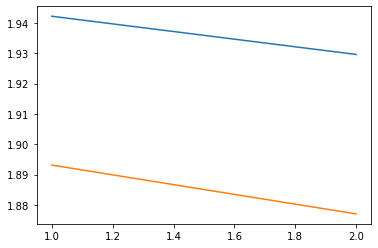

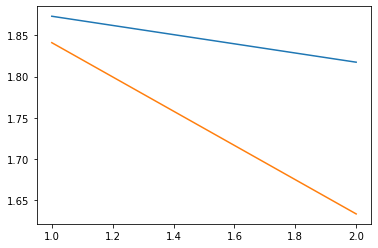

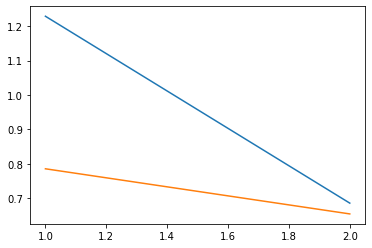

In [107]:
models = [rnn, LSTM, gru]
train_and_compare(models)

In [108]:
def predict_rnn(name, model):
    
    # No need to pad this time
    name_tensor = name_to_tensor(name)
    prediction = model(name_tensor.view(1, -1, n_letters))
    detached_prediction = prediction.detach()
    return dataset.all_categories[np.argmax(detached_prediction[0])]

In [109]:
for model in models:
    
    print(model.name)
    names = ["Hanz", 'Hans', 'Tsi', 'Roberto', 'Roberta', 'Antonowitsch', "thisisaverylongnonexistingnamewonderwhatitwilldo"]
    for name in names:
        print(name, predict_rnn(name, model))

rnn
Hanz Russian
Hans Russian
Tsi Russian
Roberto Russian
Roberta Russian
Antonowitsch Russian
thisisaverylongnonexistingnamewonderwhatitwilldo Russian
lstm
Hanz English
Hans English
Tsi Russian
Roberto Russian
Roberta Russian
Antonowitsch English
thisisaverylongnonexistingnamewonderwhatitwilldo Russian
gru
Hanz German
Hans Arabic
Tsi Russian
Roberto Spanish
Roberta Spanish
Antonowitsch Russian
thisisaverylongnonexistingnamewonderwhatitwilldo Russian
